Section 1: Working with the Dataset

In [18]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
import os
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader


In [3]:
DATA_DIR = Path("lnu-butterflies")

train_csv = pd.read_csv(DATA_DIR / "train.csv")
test_csv = pd.read_csv(DATA_DIR / "test.csv")
classes = open(DATA_DIR / "classes.txt").read().splitlines()

train_csv.head(), test_csv.head(), classes[:5]

(                                 id  \
 0  9bb25bc386d6495b9f9ae35f08e7085d   
 1  ecddd57d14c64015b906acde50307a24   
 2  50bdd6a608f04f04bb1d88721442386e   
 3  4e84f59a9a7e42eda7ba4cd6c65efe38   
 4  1fa1f3e8c2c14fe08175bcac63f16b6b   
 
                                                 path               label  
 0  train/EASTERN PINE ELFIN/9bb25bc386d6495b9f9ae...  EASTERN PINE ELFIN  
 1  train/LARGE MARBLE/ecddd57d14c64015b906acde503...        LARGE MARBLE  
 2  train/PAPER KITE/50bdd6a608f04f04bb1d887214423...          PAPER KITE  
 3  train/RED POSTMAN/4e84f59a9a7e42eda7ba4cd6c65e...         RED POSTMAN  
 4  train/GREEN HAIRSTREAK/1fa1f3e8c2c14fe08175bca...    GREEN HAIRSTREAK  ,
                                  id                                       path
 0  4cfe706486ee4561a89188090f52b9c6  test/4cfe706486ee4561a89188090f52b9c6.jpg
 1  2874a810e78844ccbedfb4ae5e54b88a  test/2874a810e78844ccbedfb4ae5e54b88a.jpg
 2  8dd78fedc88644e6baba3642d57049af  test/8dd78fedc88644e6ba

1.3 Basic dataset analysis

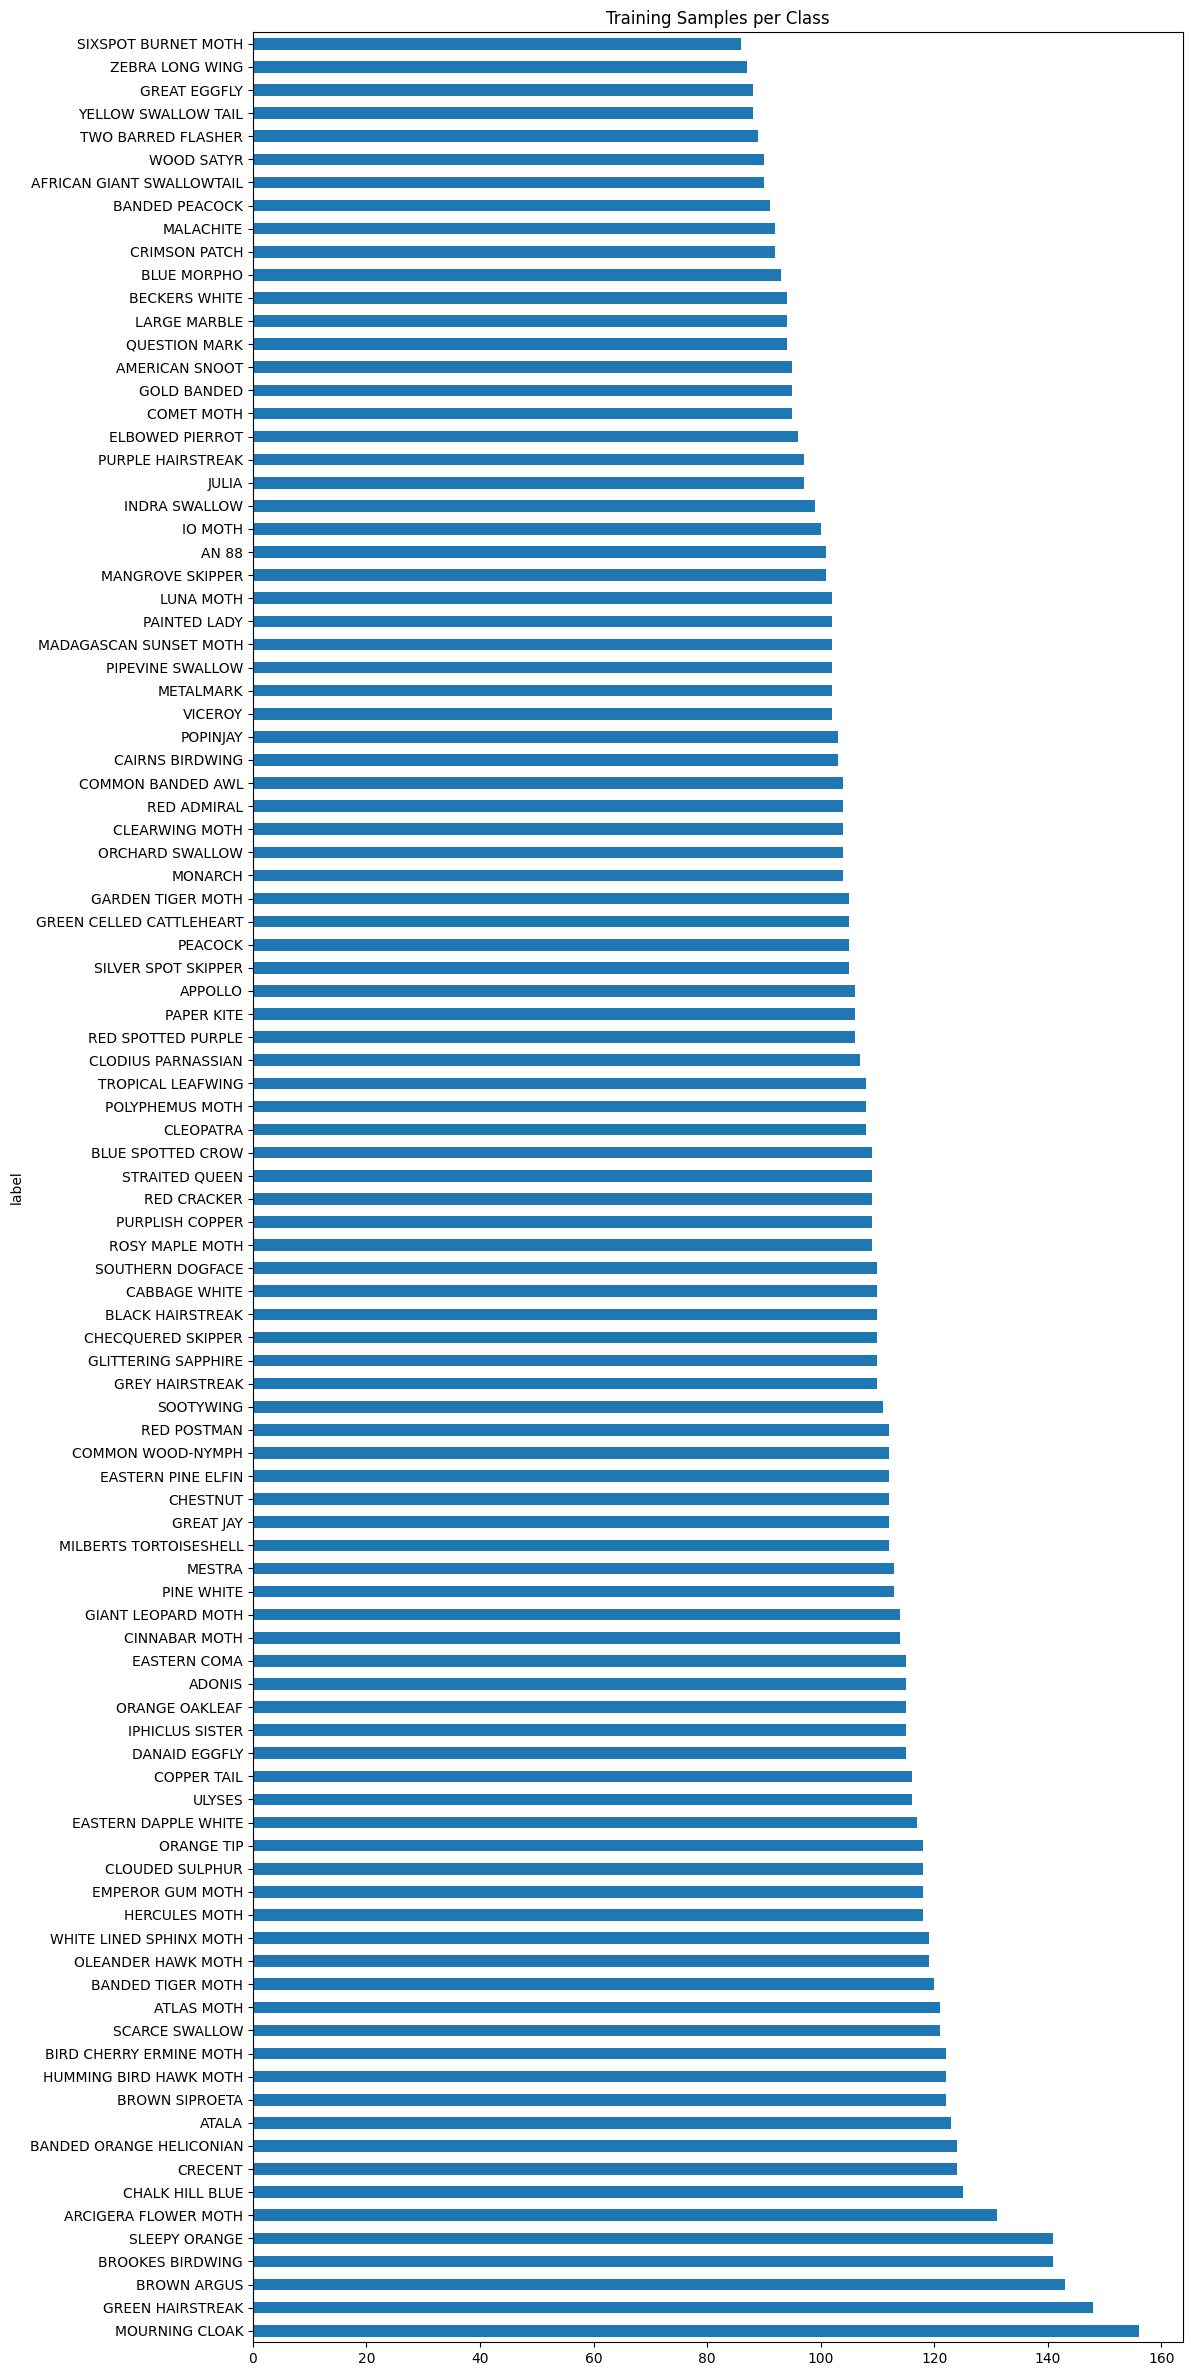

In [7]:
plt.figure(figsize=(12, 30))
train_csv['label'].value_counts().plot(kind='barh')
plt.title("Training Samples per Class")
plt.show()


1.3 Basic dataset analysis

In [8]:
print("Number of classes:", len(classes))
print("Images in train:", len(train_csv))
print("Images in test:", len(test_csv))

Number of classes: 100
Images in train: 10911
Images in test: 2728


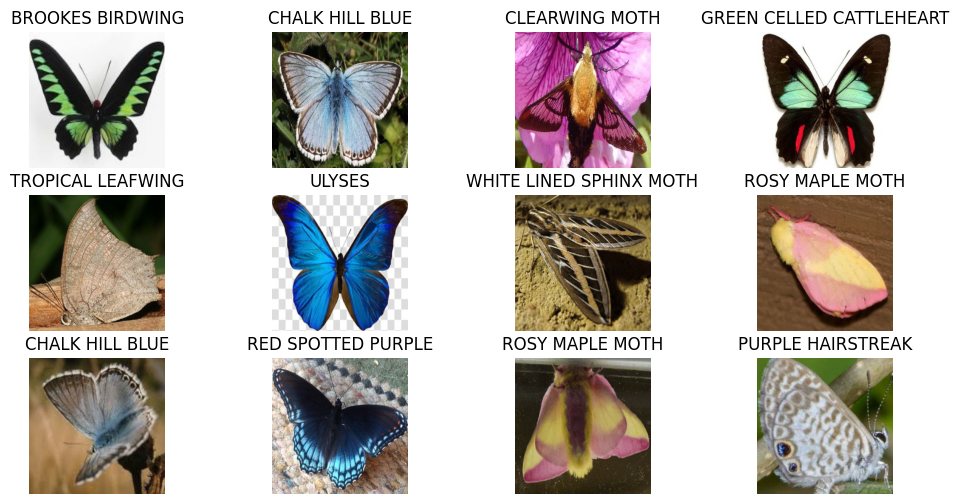

In [10]:
def show_samples(df, n=12):
    plt.figure(figsize=(12, 6))
    subset = df.sample(n)
    for i, (_, row) in enumerate(subset.iterrows()):
        img_path = DATA_DIR / row['path']
        img = Image.open(img_path)
        plt.subplot(3, 4, i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(row["label"])
    plt.show()

show_samples(train_csv, n=12)

Image shape

Image size: (224, 224)
Mode: RGB


(-0.5, 223.5, 223.5, -0.5)

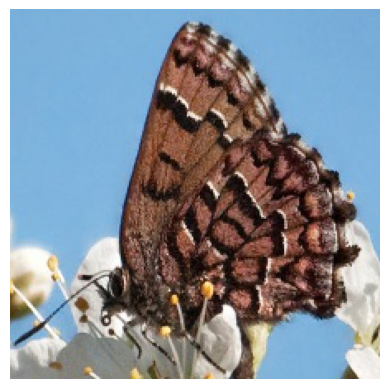

In [11]:
img_path = DATA_DIR / train_csv.iloc[0]['path']
img = Image.open(img_path)
print("Image size:", img.size)
print("Mode:", img.mode)
plt.imshow(img)
plt.axis("off")

Train/Validation Split

In [13]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(train_csv, test_size=0.1, stratify=train_csv['label'], random_state=42)

Image generation and augmentation

In [14]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

Visualizing augmentations

(-0.5, 223.5, 223.5, -0.5)

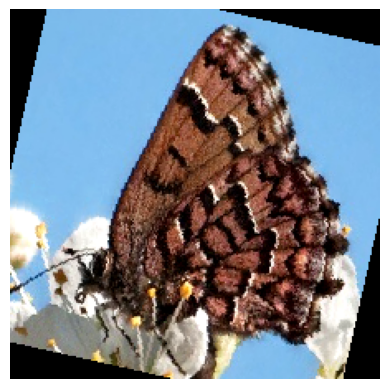

In [15]:
aug_img = train_transform(img)
plt.imshow(aug_img.permute(1, 2, 0))
plt.axis("off")

In [19]:
class ButterflyDataset(torch.utils.data.Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.root = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(self.root / row["path"]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        label = classes.index(row["class"])
        return img, label

train_dataset = ButterflyDataset(train_df, DATA_DIR, train_transform)
val_dataset   = ButterflyDataset(val_df,   DATA_DIR, val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=32)